In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from scem import gen, kernel, ebm, net
from scem import util
import scem.loss as scem_loss

In [3]:
import torch
import torch.nn as nn
import torch.distributions as dists

In [4]:
import matplotlib.pyplot as plt

In [5]:
plt.rc('lines', linewidth=2, markersize=10)
from matplotlib import rcParams
rcParams.update({'figure.autolayout': False})

In [6]:
torch.set_default_dtype(torch.double)
torch.manual_seed(13)

In [7]:
class CategoricalMixture(nn.Module):
    def __init__(self, dh1, dh2, dout, dnoise,
                 n_classes, n_logits, temperature=1.):
        super(CategoricalMixture, self).__init__()
        self.dout = dout
        self.dnoise = dnoise
        self.n_logits = n_logits
        self.n_classes = n_classes
        self.feat = net.TwoLayerFC(dnoise, dh1, dh2, dout)
        self.mlinear = net.MultipleLinear(dout, n_classes, n_logits,
                                          bias=True)
        self.temperature = temperature

    def forward(self, noise):
        return (self.feat(noise))

    def sample_noise(self, n_sample, seed=14):
        noise = torch.randn(n_sample, self.dnoise)
        return noise
    
    def in_out_shapes(self):
        return ((self.dnoise,), self.dout) 

    def sample(self, n_sample, seed=13):
        noise = self.sample_noise(n_sample, seed)
        out = self.forward(noise).relu()
        logits = self.mlinear(out)
        if self.training:
            m = dists.RelaxedOneHotCategorical(
                self.temperature,
                logits=logits,
            )
            sample = m.rsample()
            # print(sample)
            return sample
        m = dists.OneHotCategorical(logits=logits)
        sample = m.sample()
        return sample

In [8]:
class Categorical(nn.Module):
    def __init__(self, n_classes, n_logits, temperature=1.):
        super(Categorical, self).__init__()
        self.n_logits = n_logits
        self.n_classes = n_classes
        self.logits = nn.Parameter(
            torch.Tensor(n_logits, n_classes))
        self.logits = nn.init.normal_(self.logits) 
        self.temperature = temperature

    def sample(self, n_sample, seed=13):
        logits = self.logits
        with util.TorchSeedContext(seed):
            if self.training:
                m = dists.RelaxedOneHotCategorical(
                    self.temperature,
                    logits=logits,
                )
                sample = m.rsample([n_sample])
                # print(sample)
                return sample
            m = dists.OneHotCategorical(logits=logits)
            sample = m.sample([n_sample])
            return sample

In [9]:
class NeuralMachine(ebm.LatentEBM):
    
    var_type_latent = None
    var_type_obs = None

    def __init__(self, din, emb_d, n_classes, d1=10, d2=10):
        super(NeuralMachine, self).__init__()
        self.din = din
        self.emb_d = emb_d
        self.n_classs = n_classes
        
        self.W = nn.Parameter(
            torch.Tensor(emb_d, n_classes))
        self.W = nn.init.normal_(self.W) 
        self.lin1 = nn.Linear(emb_d*din, d1)
        self.lin2 = nn.Linear(d1, d2)
        self.lin3 = nn.Linear(d2, 1)

    def forward(self, X, Z):
        W = self.W
        Y = torch.einsum('ijk, dk->ijd', X, W, )
        Y = Y.reshape(Y.shape[0], -1)
        Y = self.lin1(Y).relu()
        Y = self.lin2(Y).relu()
        Y = self.lin3(Y).tanh().squeeze()
        return Y
    
    def score_marginal_obs(self, X):
        D = util.forward_diff_onehot(self.forward, 0,
                                     [X, None])
        return torch.exp(D) - 1.

In [10]:
dx = 50

In [11]:
blzm = NeuralMachine(din=dx, emb_d=3, n_classes=2)

In [12]:
cm = CategoricalMixture(100, 10, 10, 30, n_classes=2, n_logits=dx, temperature=1.)

In [13]:
c = Categorical(n_classes=2, n_logits=dx)

In [36]:
k = kernel.OHKGauss(2, torch.tensor(dx))

In [37]:
ksd = scem_loss.KSD(k, blzm.score_marginal_obs)
iksd = scem_loss.IncompleteKSD(k, blzm.score_marginal_obs)

In [38]:
opt_cm = torch.optim.Adam(cm.parameters(), lr=1e-3,
                          weight_decay=0.)
opt_c = torch.optim.Adam(c.parameters(), lr=1e-3,
                          weight_decay=0.)
niter = 300
n = 300
test_n = 300
batch_size = 100

In [39]:
def get_minibatch(batch_size, X, detach=True):
    perm = torch.randperm(X.shape[0]).detach()
    idx = perm[:batch_size]
    X_ = X[idx]
    if detach:
        X_ = X_.detach()
    return X_

In [40]:
losses = []
for i in range(niter):
    X = cm.sample(n, seed=0)
    # loss = ksd.loss(X)
    i1, i2 = util.sample_incomplete_ustat_batch(n, batch_size)
    loss = iksd.loss(X[i1], X[i2])
    opt_cm.zero_grad()
    loss.backward(retain_graph=False)
    opt_cm.step()   
    if i % 1 == 0:
        cm.eval()
        X_ = cm.sample(test_n, seed=i)
        test_loss = ksd.loss(X_)
        cm.train()
        print(test_loss.item())
        losses += [test_loss.item()]

-0.0004828746181668339
0.0014482136023128828
0.0023830518843931375
2.929340219196806e-05
-0.0006897552422981474
0.0004027403361348956
-0.00016410497275065266
-0.0009453144079889186
0.0007830735500087311
-9.15384969693132e-05
0.00106079833313254
7.047450501784841e-05
-0.0005205366554206506
-0.00087363144106545
0.0014099576061479514
-0.0008275698577217868
-0.00013601143184401723
0.0011672399051910311
0.0022477032655000913
0.00017668388506699852
0.002740200649415475


KeyboardInterrupt: 

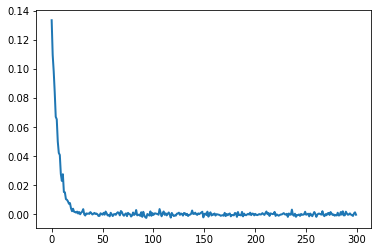

In [21]:
plt.plot(losses)

In [22]:
c_losses = []
for i in range(niter):
    X = c.sample(n, seed=0)
    loss = ksd.loss(X)
    opt_c.zero_grad()
    loss.backward(retain_graph=False)
    opt_c.step()   
    if i % 1 == 0:
        c.eval()
        X_ = c.sample(test_n, seed=i)
        test_loss = ksd.loss(X_)
        c.train()
        print(test_loss.item())
        c_losses += [test_loss.item()]

0.544359853074965
0.5756639927000333
0.5500342842997071
0.5602590908628381
0.5627531427770522
0.5546038384824741
0.5641365766675774
0.5550280196674231
0.5581923930691648
0.5600303967444079
0.5503532530080854
0.5413238411697349
0.5311872200709414
0.5278210669832445
0.5063871633193584
0.5297217907998866
0.5043919035464934
0.5499611682574262
0.5189052884910064
0.5164246795001534
0.5435772206982387
0.5047438027898812
0.5212567714805563
0.4886458543386748
0.5204634893448367
0.542580264829701
0.4941387044503254
0.5361322635653678
0.5142198076502517
0.5174621956216685
0.5372078352787366
0.5160024419191047
0.509410203733474
0.5341390631885007
0.5034085466424331
0.510410972363878
0.5537937481501776
0.5456877503683223
0.4806900742597867
0.5009626095991028
0.5097068984977905
0.5054138684460979
0.514234869243539
0.4678844807144905
0.4966512861673527
0.49639443765139585
0.48897316147590536
0.4917393652123577
0.5119155029477123
0.4923034778565115
0.47404254204539026
0.5015340053291544
0.480262480380

In [33]:
import numpy as np
losses_ = [np.abs(l) for l in losses]
c_losses_ = [np.abs(l) for l in c_losses]

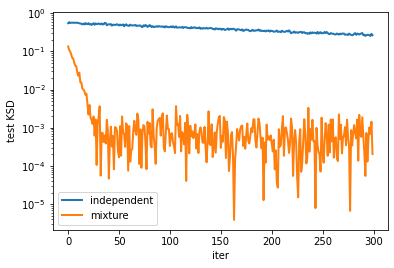

In [34]:
plt.plot(c_losses_, label='independent')
plt.plot(losses_, label='mixture')
plt.xlabel('iter')
plt.ylabel('test KSD')
plt.yscale('log')

plt.legend()